# [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)
(Прогнозирование биологического ответа)

##### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  
* Каждая строка представляет молекулу. 
* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. 

Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. 

Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

[Скачать данные](https://lms.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_train_sem09__1_.zip)

In [1]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные моделиё
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split # сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Знакомство с данными и их исследование

In [3]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


In [4]:
TARGET_FEATURE = 'Activity'

Проверяем наличие пропусков

In [5]:
empty_cols = data.isnull().sum()
empty_cols[empty_cols > 0]

Series([], dtype: int64)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Смотрим на сбалансированность классов:

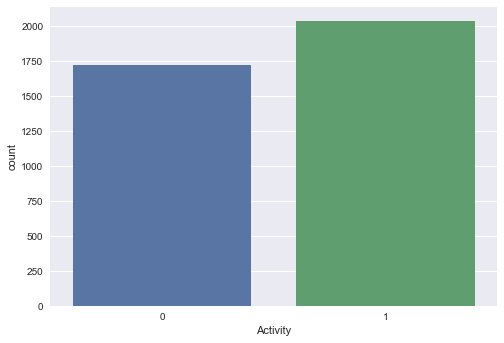

In [7]:
sns.countplot(data=data, x=TARGET_FEATURE);

In [8]:
data[TARGET_FEATURE].value_counts(True) * 100

1    54.22554
0    45.77446
Name: Activity, dtype: float64

Классы немного не сбалансированны. Использую стратификацию при разделении выборки.

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [9]:
X, y = data.drop(columns=TARGET_FEATURE), data[TARGET_FEATURE]

* Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
* Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [11]:
random_state = 42

# **Логистическая регрессия**
### С гиперпараметрами по умолчанию

In [12]:
# Создаем объект класса логистическая регрессия
model = linear_model.LogisticRegression(max_iter=10000)

# Обучаем модель, минимизируя logloss
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.89
f1_score на test наборе: 0.78


## Подбор гиперпараметров
#### GridSearchCV для алгоритма логистической регрессии

In [12]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

model = linear_model.LogisticRegression(
        random_state=random_state, # генератор случайных чисел
        max_iter=1000 # количество итераций на сходимость
    )

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1'
)

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 1.14 s
Wall time: 14min 22s
f1_score на train наборе: 0.84
f1_score на test наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


14мин ушло на поиск гиперпараметров по сетке и без кросс-валидации. При этом метрика на тестовой выборке не улучшилась

### GridSearchCV для алгоритма логистической регрессии с кросс-валидацией

In [13]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

model = linear_model.LogisticRegression(random_state=random_state, max_iter=10000)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=skf,
    n_jobs=-1,
    scoring='f1'
)

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

### RandomizedSearchCV для алгоритма логистической регрессии с кросс-валидацией

In [14]:
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

model = linear_model.LogisticRegression(random_state=random_state, max_iter=10000)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)        

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=skf,
    n_jobs=-1,
    scoring='f1'
)

%time random_search.fit(X_train, y_train)
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 5.72 s
Wall time: 9min 25s
f1_score на train наборе: 0.87
f1_score на test наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.23}


9мин ушло алгоритму случайного поиска с кросс валидацией, метрика осталась на том же уровне, но временеи ушло значительном меньше.

### Hyperopt

In [25]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

In [25]:
penalty_lst = ['l1', 'l2']
solver_lst = ['liblinear', 'saga']

space = {
    'penalty': hp.choice('penalty', penalty_lst), # тип регуляризации
    'solver': hp.choice('solver', solver_lst), # алгоритм оптимизации
    'C': hp.quniform('C', 0.01, 1, 0.01), # уровень силы регурялизации
}

In [26]:
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # создаем модель
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=10000)
    
    if cv > 0:
        # Создаём объект кросс-валидатора k-fold со стратификацией
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        
        # Считаем метрики на кросс-валидации k-fold со стратификацией
        cv_metrics = model_selection.cross_validate(
            estimator=model, # модель
            X=X, # матрица наблюдений X
            y=y, # вектор ответов y
            cv=skf, # кросс-валидатор
            scoring='f1', # метрика
            n_jobs=-1, # использовать все ядра
            return_train_score=False # подсчёт метрики на тренировочных фолдах
        )
        score = np.mean(cv_metrics['test_score'])
    else:
        # обучаем модель без кросс валидации
        model.fit(X, y)
        score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [27]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 7/7 [04:39<00:00, 39.96s/trial, best loss: -0.784741888014802] 
Наилучшие значения гиперпараметров {'C': 0.17, 'penalty': 1, 'solver': 1}
CPU times: total: 406 ms
Wall time: 4min 39s


### Модель логистической регрессии на гиперпараметрах полученных с помощью Hyperopt

In [29]:
# Создаем объект класса логистическая регрессия
model = linear_model.LogisticRegression(C=best['C'], 
                                          penalty=penalty_lst[best['penalty']], 
                                          solver=solver_lst[best['solver']], 
                                          max_iter=10000)

# Обучаем модель, минимизируя logloss
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.86
f1_score на test наборе: 0.79


Получено улучшение значения метрики на тестовой выборке при существенном уменьшений времени на обучение

### Optuna

In [16]:
import optuna

In [33]:
def optuna_lr(trial, cv=5, X=X_train, y=y_train):
  # задаем пространства поиска гиперпараметров
  solver0 = trial.suggest_categorical('solver0', ['liblinear', 'saga', 'lbfgs', 'sag']) # алгоритм оптимизации
  C = trial.suggest_float(name='C', low=0.01, high=1, step=0.01) # уровень силы регурялизации
  
  if solver0 == 'sag' or solver0 == 'lbfgs':
    penalty = trial.suggest_categorical('penalty1', ['l2', 'none'])
    solver = trial.suggest_categorical('solver1', ['lbfgs', 'sag'])
  else:
    penalty = trial.suggest_categorical('penalty2', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver2', ['liblinear', 'saga'])
 
  model = linear_model.LogisticRegression(solver=solver,
                                          C=C,
                                          penalty=penalty,
                                          max_iter=10000)
     
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X, # матрица наблюдений X
        y=y, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        n_jobs=-1,
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель без кросс-валидации
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
  
  return score

In [34]:
%%time
# cоздаем объект исследования, указываем максимизацию метрики f1
study = optuna.create_study(study_name='LogisticRegression', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=10)

[I 2022-09-17 17:25:48,317] A new study created in memory with name: LogisticRegression
[I 2022-09-17 17:25:49,777] Trial 0 finished with value: 0.7766892475656103 and parameters: {'solver0': 'liblinear', 'C': 0.75, 'penalty2': 'l1', 'solver2': 'liblinear'}. Best is trial 0 with value: 0.7766892475656103.
[I 2022-09-17 17:25:51,129] Trial 1 finished with value: 0.7762181620109898 and parameters: {'solver0': 'saga', 'C': 0.78, 'penalty2': 'l1', 'solver2': 'liblinear'}. Best is trial 0 with value: 0.7766892475656103.
[I 2022-09-17 17:25:52,246] Trial 2 finished with value: 0.7693796880367267 and parameters: {'solver0': 'saga', 'C': 0.77, 'penalty2': 'l2', 'solver2': 'liblinear'}. Best is trial 0 with value: 0.7766892475656103.
[I 2022-09-17 17:30:15,948] Trial 3 finished with value: 0.7349104774147304 and parameters: {'solver0': 'lbfgs', 'C': 0.76, 'penalty1': 'none', 'solver1': 'sag'}. Best is trial 0 with value: 0.7766892475656103.
[I 2022-09-17 17:30:16,933] Trial 4 finished with valu

CPU times: total: 484 ms
Wall time: 13min 25s


In [35]:
print('Best f1 value:', study.best_value)
print('Best params:', study.best_params)

Best f1 value: 0.7870028171445476
Best params: {'solver0': 'liblinear', 'C': 0.3, 'penalty2': 'l1', 'solver2': 'liblinear'}


### Модель логистической регрессии на гиперпараметрах полученных с помощью Optuna

In [36]:
# Создаем объект класса логистическая регрессия
model = linear_model.LogisticRegression(C=0.3, penalty='l1', solver='liblinear', max_iter=10000)

# Обучаем модель, минимизируя logloss
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.84
f1_score на test наборе: 0.78


# ***Случайный лес***
### С гиперпараметрами по умолчанию

In [27]:
# Создаем объект класса случайный лес
model = ensemble.RandomForestClassifier(random_state=random_state)

# Обучаем модель
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 1.00
f1_score на test наборе: 0.80


## Подбор гиперпараметров
#### GridSearchCV для алгоритма случайного леса

In [22]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 40, 10, dtype=int))
              }

model = ensemble.RandomForestClassifier(random_state=random_state)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1'
)

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 35 s
Wall time: 23min 24s
f1_score на train наборе: 0.92
f1_score на test наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 14, 'min_samples_leaf': 6, 'n_estimators': 110}


#### GridSearchCV для алгоритма случайного леса с кросс-валидацией

In [23]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 40, 10, dtype=int))
              }

model = ensemble.RandomForestClassifier(random_state=random_state)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=skf,
    n_jobs=-1,
    scoring='f1'
)

%time grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 34.7 s
Wall time: 22min 52s
f1_score на train наборе: 0.94
f1_score на test наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 27, 'min_samples_leaf': 5, 'n_estimators': 140}


### RandomizedSearchCV для алгоритма случайного леса с кросс-валидацией

In [25]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 40, 10, dtype=int))
              }

model = ensemble.RandomForestClassifier(random_state=random_state)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)      

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=skf,
    n_jobs=-1,
    scoring='f1'
)

%time random_search.fit(X_train, y_train)
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 1.39 s
Wall time: 8.36 s
f1_score на train наборе: 0.93
f1_score на test наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 6, 'max_depth': 22}


### Hyperopt

In [44]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 100, 1),
    'max_depth': hp.quniform('max_depth', 1, 100, 1)
}

In [45]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']),
              'min_samples_leaf': int(params['min_samples_leaf']), 
              'max_depth': int(params['max_depth'])
    }
    
    # создаем модель
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    if cv > 0:
        # Создаём объект кросс-валидатора k-fold со стратификацией
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        
        # Считаем метрики на кросс-валидации k-fold со стратификацией
        cv_metrics = model_selection.cross_validate(
            estimator=model, # модель
            X=X, # матрица наблюдений X
            y=y, # вектор ответов y
            cv=skf, # кросс-валидатор
            scoring='f1', # метрика
            n_jobs=-1, # использовать все ядра
            return_train_score=False # подсчёт метрики на тренировочных фолдах
        )
        score = np.mean(cv_metrics['test_score'])
    else:
        # обучаем модель без кросс валидации
        model.fit(X, y)
        score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [46]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 30/30 [00:54<00:00,  1.81s/trial, best loss: -0.8109690514497506]
Наилучшие значения гиперпараметров {'max_depth': 19.0, 'min_samples_leaf': 5.0, 'n_estimators': 151.0}
CPU times: total: 2.2 s
Wall time: 54.2 s


In [48]:
# Для словаря найденных параметров делаю округление и приведение типов к целому
best = {key: int(val.round()) for (key, val) in best.items()}

### Модель случайного леса на гиперпараметрах полученных с помощью Hyperopt

In [49]:
# Создаем объект класса случайный лес
model = ensemble.RandomForestClassifier(**best, random_state=random_state)

# Обучаем модель
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.94
f1_score на test наборе: 0.80


### Optuna

In [50]:
def optuna_rf(trial, cv=5, X=X_train, y=y_train):
  params = {'n_estimators': trial.suggest_int('n_estimators', 50, 300, 1),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100, 1),
              'max_depth': trial.suggest_int('max_depth', 1, 100, 1)
    }
 
  # создаем модель
  model = ensemble.RandomForestClassifier(**params, random_state=random_state)
  
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X, # матрица наблюдений X
        y=y, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        n_jobs=-1,
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель без кросс-валидации
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
  
  return score

In [51]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику через direction
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2022-09-17 15:31:31,320] A new study created in memory with name: RandomForestClassifier
[I 2022-09-17 15:31:34,062] Trial 0 finished with value: 0.7713618772053892 and parameters: {'n_estimators': 135, 'min_samples_leaf': 31, 'max_depth': 72}. Best is trial 0 with value: 0.7713618772053892.
[I 2022-09-17 15:31:35,616] Trial 1 finished with value: 0.7570149466974554 and parameters: {'n_estimators': 75, 'min_samples_leaf': 12, 'max_depth': 5}. Best is trial 0 with value: 0.7713618772053892.
[I 2022-09-17 15:31:37,391] Trial 2 finished with value: 0.7518521412023664 and parameters: {'n_estimators': 238, 'min_samples_leaf': 68, 'max_depth': 10}. Best is trial 0 with value: 0.7713618772053892.
[I 2022-09-17 15:31:38,929] Trial 3 finished with value: 0.7884175539859724 and parameters: {'n_estimators': 127, 'min_samples_leaf': 18, 'max_depth': 18}. Best is trial 3 with value: 0.7884175539859724.
[I 2022-09-17 15:31:40,740] Trial 4 finished with value: 0.812954102066192 and parameters: {'n

CPU times: total: 2.03 s
Wall time: 57.9 s


In [52]:
print('Best f1 value:', study.best_value)
print('Best params:', study.best_params)

Best f1 value: 0.812954102066192
Best params: {'n_estimators': 107, 'min_samples_leaf': 5, 'max_depth': 19}


### Модель случайного леса на гиперпараметрах полученных с помощью Optuna

In [53]:
# Создаем объект класса случайный лес
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)

# Обучаем модель
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.94
f1_score на test наборе: 0.80
